# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

# Dataset Load

We download MNIST dataset, consisting of 60.000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale.

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)


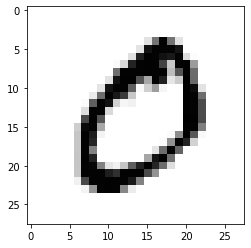

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
plt.imshow(X_train[1], cmap = 'Greys')
print(X_train.shape)

## Preprocessing data

The pixels in the source image are within the range [0, 256] we will normalize this range to [-1, 1] in order to treat this information with neural networks.

In [ ]:
X_train = X_train.astype('float32')/127.5 -1

X_train = np.expand_dims(X_train, axis=3)

# Generator definition

In [ ]:
def create_generator():
    input = Input(shape=(100))

    x = Dense(256, activation='relu')(input)
    x = Dense(512, activation='relu')(x)

    x = Dense(28*28, activation='tanh')(x)
    output = Reshape((28, 28, 1))(x)

    generator = Model(input, output)

    return generator

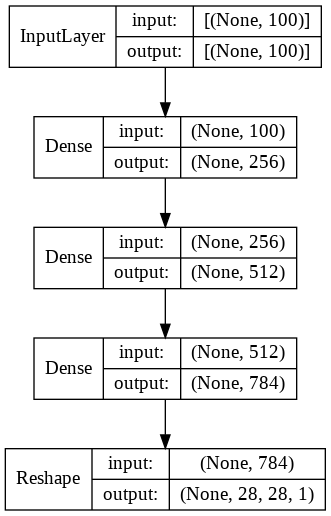

In [ ]:
generator = create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

# Discriminator definition

In [ ]:
def create_discriminator():
    input = Input(shape=(28, 28, 1))

    x = Flatten()(input)

    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)

    output = Dense(1, activation='sigmoid')(x)

    discriminator = Model(input, output)

    return discriminator

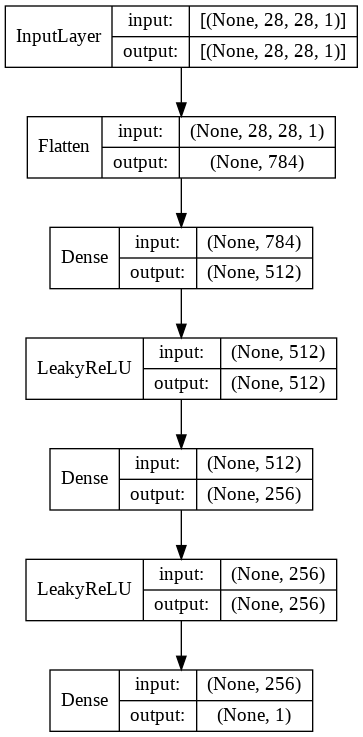

In [ ]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

# GAN model definition

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
img = generator(z)
validity = discriminator(img)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

# Training

In [ ]:
def train(X_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (0 fake and 1 real)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Train the Discriminator
            noise = np.random.normal(0, 1, (batch_size, 100))
            gen_imgs = generator.predict(noise, verbose=0)
            imgs = X_train[batch*batch_size : (batch+1)*batch_size]

            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = combined.train_on_batch(noise, valid)

            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[1])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[1], g_loss))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, imgs)

        plot_losses(history)

## Plotting functions

In [ ]:
def sample_images(epoch, batch, gen_imgs, imgs):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0,i].imshow(gen_imgs[i,:,:,0], cmap='Greys')
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(imgs[i,:,:,0], cmap='Greys')
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [ ]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

----EPOCH 0-----
0 [D loss: 0.0000,	 acc.: 100.00%]	[G loss: 16.3421]


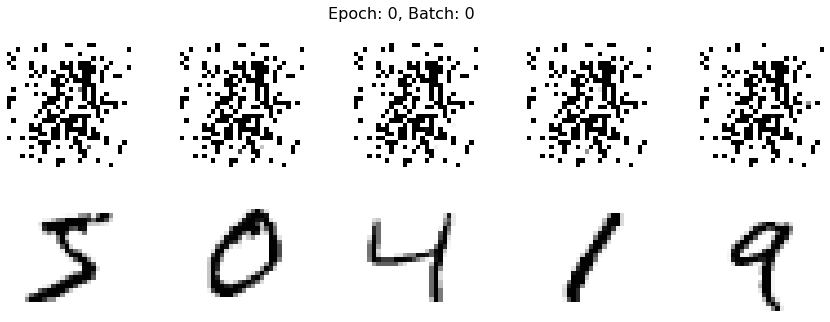

50 [D loss: 11.6116,	 acc.: 50.00%]	[G loss: 0.0000]
100 [D loss: 12.0255,	 acc.: 50.00%]	[G loss: 0.0000]
150 [D loss: 12.1085,	 acc.: 50.00%]	[G loss: 0.0000]
200 [D loss: 13.3968,	 acc.: 50.00%]	[G loss: 0.0000]
250 [D loss: 12.2531,	 acc.: 50.00%]	[G loss: 0.0000]
300 [D loss: 12.3960,	 acc.: 50.00%]	[G loss: 0.0000]
350 [D loss: 12.3155,	 acc.: 50.00%]	[G loss: 0.0000]
400 [D loss: 12.9826,	 acc.: 50.00%]	[G loss: 0.0000]
450 [D loss: 12.4664,	 acc.: 50.00%]	[G loss: 0.0000]
500 [D loss: 12.1602,	 acc.: 50.00%]	[G loss: 0.0000]


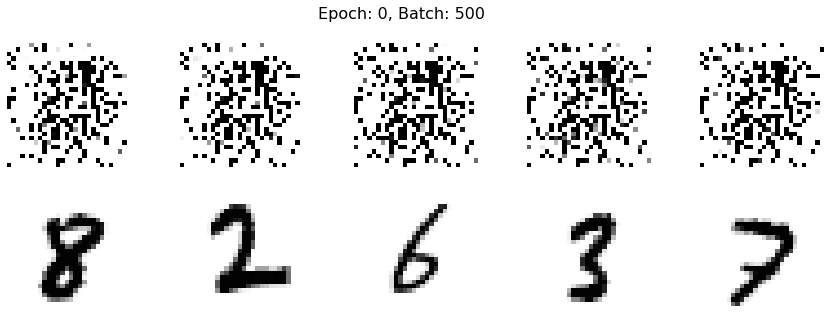

550 [D loss: 12.8512,	 acc.: 48.44%]	[G loss: 0.0000]
600 [D loss: 12.4387,	 acc.: 50.00%]	[G loss: 0.0000]
650 [D loss: 11.9023,	 acc.: 50.00%]	[G loss: 0.0000]
700 [D loss: 13.0542,	 acc.: 50.00%]	[G loss: 0.0000]
750 [D loss: 12.8724,	 acc.: 50.00%]	[G loss: 0.0000]
800 [D loss: 12.3274,	 acc.: 50.00%]	[G loss: 0.0000]
850 [D loss: 15.0203,	 acc.: 50.00%]	[G loss: 0.0000]
900 [D loss: 15.9453,	 acc.: 50.00%]	[G loss: 0.0000]
950 [D loss: 15.6435,	 acc.: 50.00%]	[G loss: 0.0000]
1000 [D loss: 16.1824,	 acc.: 50.00%]	[G loss: 0.0000]


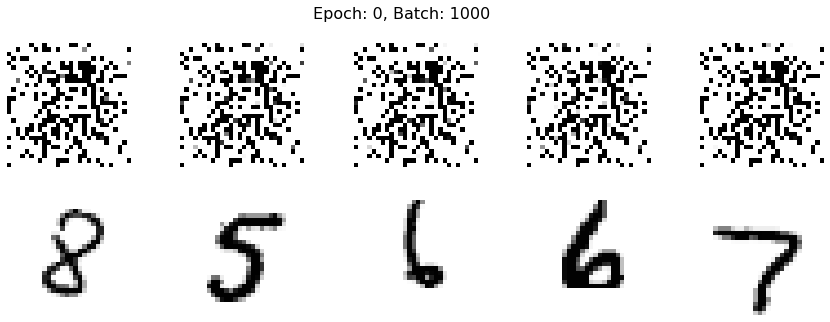

1050 [D loss: 17.0480,	 acc.: 50.00%]	[G loss: 0.0000]
1100 [D loss: 15.8831,	 acc.: 50.00%]	[G loss: 0.0000]
1150 [D loss: 16.4719,	 acc.: 50.00%]	[G loss: 0.0000]
1200 [D loss: 16.4542,	 acc.: 50.00%]	[G loss: 0.0000]
1250 [D loss: 16.2168,	 acc.: 50.00%]	[G loss: 0.0000]
1300 [D loss: 16.0390,	 acc.: 50.00%]	[G loss: 0.0000]
1350 [D loss: 16.5692,	 acc.: 50.00%]	[G loss: 0.0000]
1400 [D loss: 15.7993,	 acc.: 50.00%]	[G loss: 0.0000]
1450 [D loss: 17.1593,	 acc.: 50.00%]	[G loss: 0.0000]
1500 [D loss: 16.5782,	 acc.: 50.00%]	[G loss: 0.0000]


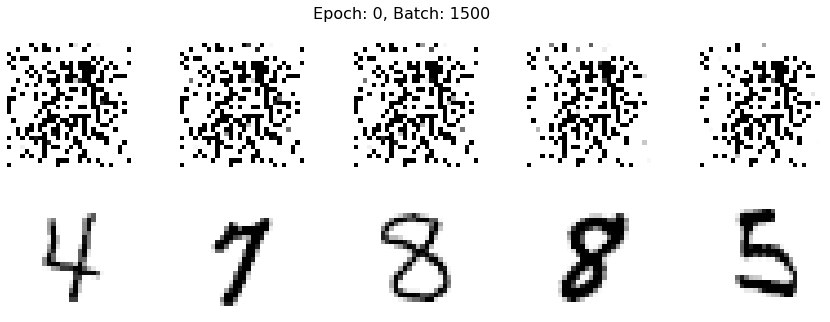

1550 [D loss: 16.4208,	 acc.: 50.00%]	[G loss: 0.0000]
1600 [D loss: 16.4546,	 acc.: 50.00%]	[G loss: 0.0000]
1650 [D loss: 16.8366,	 acc.: 50.00%]	[G loss: 0.0000]
1700 [D loss: 16.1467,	 acc.: 50.00%]	[G loss: 0.0000]
1750 [D loss: 16.2138,	 acc.: 50.00%]	[G loss: 0.0000]
1800 [D loss: 16.2008,	 acc.: 50.00%]	[G loss: 0.0000]
1850 [D loss: 16.7222,	 acc.: 50.00%]	[G loss: 0.0000]


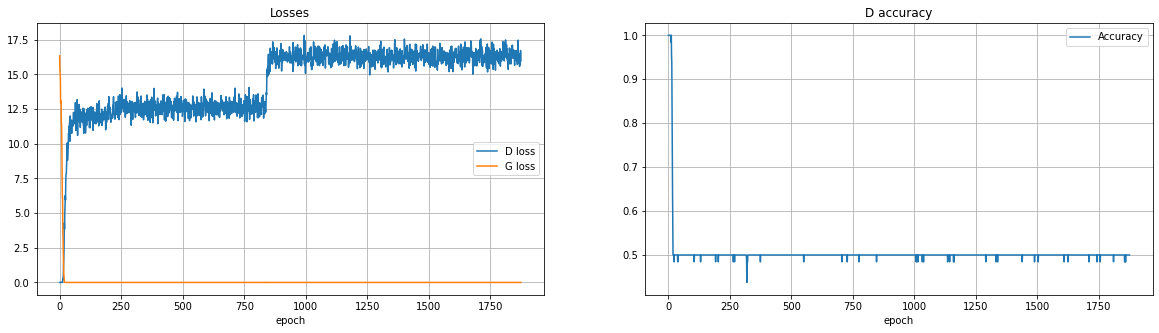

----EPOCH 1-----
0 [D loss: 16.7180,	 acc.: 50.00%]	[G loss: 0.0000]


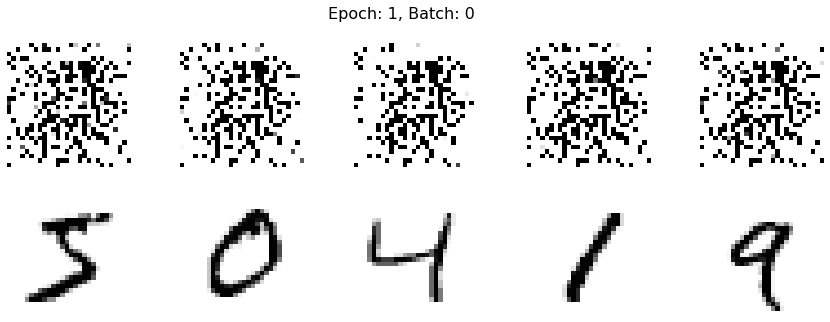

50 [D loss: 16.1245,	 acc.: 50.00%]	[G loss: 0.0000]
100 [D loss: 16.4816,	 acc.: 50.00%]	[G loss: 0.0000]
150 [D loss: 16.0364,	 acc.: 50.00%]	[G loss: 0.0000]
200 [D loss: 16.5424,	 acc.: 50.00%]	[G loss: 0.0000]
250 [D loss: 15.8739,	 acc.: 50.00%]	[G loss: 0.0000]
300 [D loss: 16.7127,	 acc.: 50.00%]	[G loss: 0.0000]
350 [D loss: 16.9668,	 acc.: 50.00%]	[G loss: 0.0000]
400 [D loss: 15.5382,	 acc.: 50.00%]	[G loss: 0.0000]
450 [D loss: 16.8913,	 acc.: 50.00%]	[G loss: 0.0000]
500 [D loss: 16.4857,	 acc.: 50.00%]	[G loss: 0.0000]


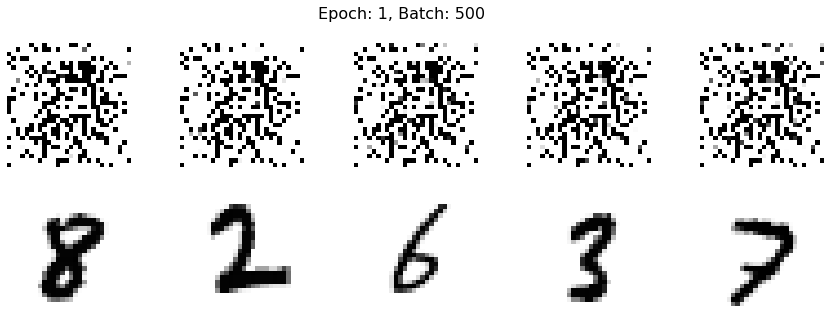

550 [D loss: 16.7798,	 acc.: 48.44%]	[G loss: 0.0000]
600 [D loss: 16.0116,	 acc.: 50.00%]	[G loss: 0.0000]
650 [D loss: 16.6973,	 acc.: 50.00%]	[G loss: 0.0000]
700 [D loss: 16.2711,	 acc.: 50.00%]	[G loss: 0.0000]
750 [D loss: 15.8897,	 acc.: 50.00%]	[G loss: 0.0000]
800 [D loss: 16.1547,	 acc.: 50.00%]	[G loss: 0.0000]
850 [D loss: 16.2860,	 acc.: 50.00%]	[G loss: 0.0000]
900 [D loss: 16.6990,	 acc.: 50.00%]	[G loss: 0.0000]
950 [D loss: 15.6830,	 acc.: 50.00%]	[G loss: 0.0000]
1000 [D loss: 15.7492,	 acc.: 50.00%]	[G loss: 0.0000]


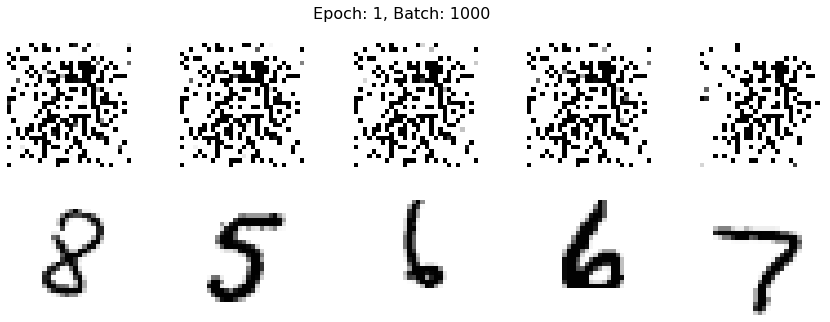

1050 [D loss: 16.8000,	 acc.: 50.00%]	[G loss: 0.0000]
1100 [D loss: 16.1394,	 acc.: 50.00%]	[G loss: 0.0000]
1150 [D loss: 15.9614,	 acc.: 50.00%]	[G loss: 0.0000]
1200 [D loss: 15.9437,	 acc.: 50.00%]	[G loss: 0.0000]
1250 [D loss: 16.0795,	 acc.: 50.00%]	[G loss: 0.0000]
1300 [D loss: 15.9507,	 acc.: 50.00%]	[G loss: 0.0000]
1350 [D loss: 15.7023,	 acc.: 50.00%]	[G loss: 0.0000]
1400 [D loss: 16.9812,	 acc.: 50.00%]	[G loss: 0.0000]
1450 [D loss: 16.2509,	 acc.: 50.00%]	[G loss: 0.0000]
1500 [D loss: 16.3656,	 acc.: 50.00%]	[G loss: 0.0000]


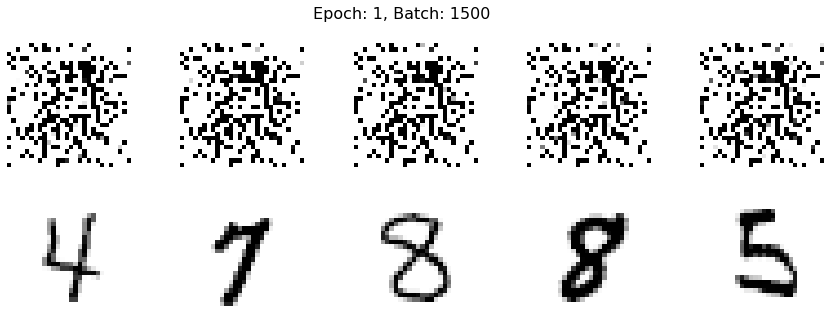

1550 [D loss: 16.4449,	 acc.: 50.00%]	[G loss: 0.0000]
1600 [D loss: 16.0094,	 acc.: 50.00%]	[G loss: 0.0000]
1650 [D loss: 16.0262,	 acc.: 50.00%]	[G loss: 0.0000]
1700 [D loss: 16.1370,	 acc.: 50.00%]	[G loss: 0.0000]
1750 [D loss: 15.8814,	 acc.: 50.00%]	[G loss: 0.0000]
1800 [D loss: 16.1635,	 acc.: 50.00%]	[G loss: 0.0000]
1850 [D loss: 16.2886,	 acc.: 50.00%]	[G loss: 0.0000]


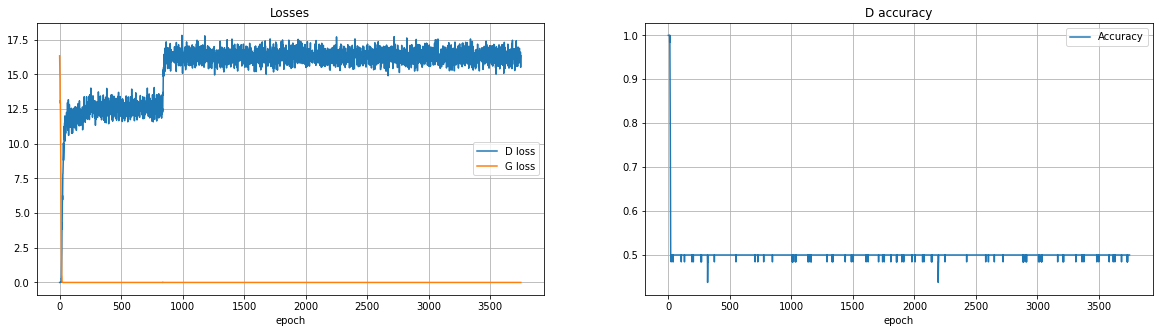

----EPOCH 2-----
0 [D loss: 15.9563,	 acc.: 50.00%]	[G loss: 0.0000]


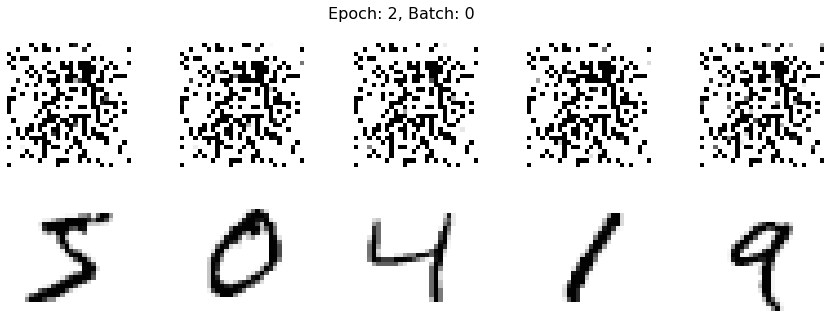

50 [D loss: 15.8338,	 acc.: 50.00%]	[G loss: 0.0000]
100 [D loss: 15.8565,	 acc.: 50.00%]	[G loss: 0.0000]
150 [D loss: 16.1174,	 acc.: 50.00%]	[G loss: 0.0000]
200 [D loss: 16.1909,	 acc.: 50.00%]	[G loss: 0.0000]
250 [D loss: 16.2459,	 acc.: 50.00%]	[G loss: 0.0000]
300 [D loss: 16.8107,	 acc.: 50.00%]	[G loss: 0.0000]
350 [D loss: 16.6697,	 acc.: 50.00%]	[G loss: 0.0000]
400 [D loss: 15.7039,	 acc.: 50.00%]	[G loss: 0.0000]
450 [D loss: 15.3145,	 acc.: 50.00%]	[G loss: 0.0000]
500 [D loss: 15.3916,	 acc.: 50.00%]	[G loss: 0.0000]


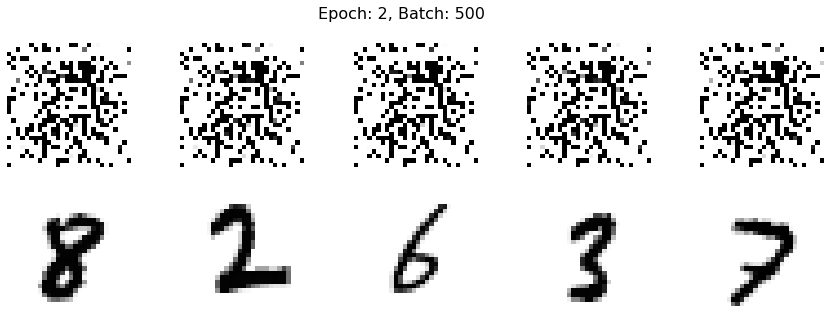

550 [D loss: 15.9969,	 acc.: 48.44%]	[G loss: 0.0000]
600 [D loss: 16.2813,	 acc.: 50.00%]	[G loss: 0.0000]
650 [D loss: 16.0258,	 acc.: 50.00%]	[G loss: 0.0000]
700 [D loss: 16.5273,	 acc.: 50.00%]	[G loss: 0.0000]
750 [D loss: 15.8192,	 acc.: 50.00%]	[G loss: 0.0000]
800 [D loss: 16.1557,	 acc.: 50.00%]	[G loss: 0.0000]
850 [D loss: 16.5387,	 acc.: 50.00%]	[G loss: 0.0000]
900 [D loss: 16.2354,	 acc.: 50.00%]	[G loss: 0.0000]
950 [D loss: 16.9553,	 acc.: 50.00%]	[G loss: 0.0000]
1000 [D loss: 16.0869,	 acc.: 50.00%]	[G loss: 0.0000]


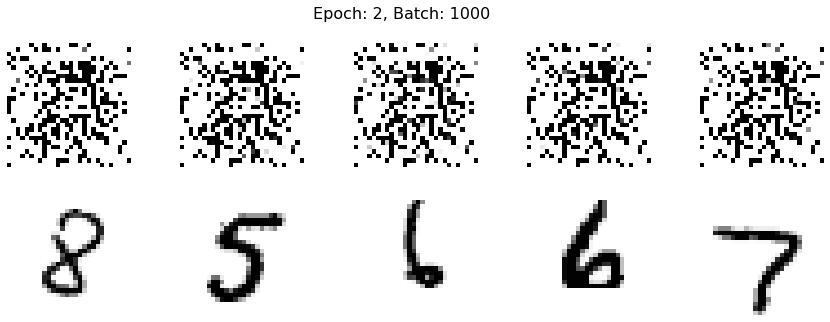

1050 [D loss: 16.6357,	 acc.: 50.00%]	[G loss: 0.0000]
1100 [D loss: 16.2854,	 acc.: 50.00%]	[G loss: 0.0000]
1150 [D loss: 16.5038,	 acc.: 50.00%]	[G loss: 0.0000]
1200 [D loss: 15.6684,	 acc.: 50.00%]	[G loss: 0.0000]
1250 [D loss: 16.2703,	 acc.: 50.00%]	[G loss: 0.0000]
1300 [D loss: 16.1698,	 acc.: 50.00%]	[G loss: 0.0000]
1350 [D loss: 15.8517,	 acc.: 50.00%]	[G loss: 0.0000]
1400 [D loss: 16.3987,	 acc.: 50.00%]	[G loss: 0.0000]
1450 [D loss: 16.9517,	 acc.: 50.00%]	[G loss: 0.0000]
1500 [D loss: 15.5532,	 acc.: 50.00%]	[G loss: 0.0000]


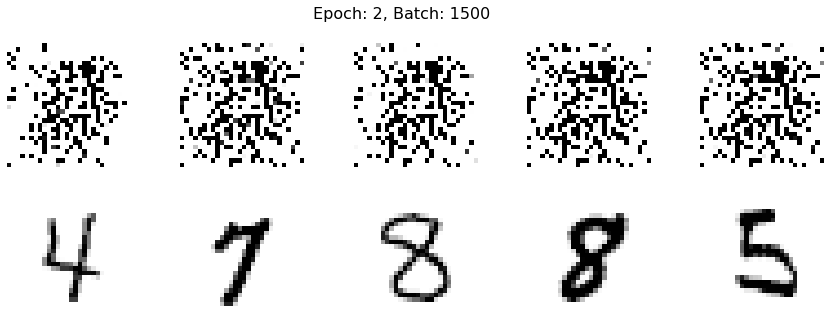

1550 [D loss: 17.0550,	 acc.: 50.00%]	[G loss: 0.0000]
1600 [D loss: 17.1611,	 acc.: 50.00%]	[G loss: 0.0000]
1650 [D loss: 16.4853,	 acc.: 50.00%]	[G loss: 0.0000]
1700 [D loss: 16.7943,	 acc.: 50.00%]	[G loss: 0.0000]
1750 [D loss: 16.3117,	 acc.: 50.00%]	[G loss: 0.0000]
1800 [D loss: 15.7644,	 acc.: 50.00%]	[G loss: 0.0000]
1850 [D loss: 16.3124,	 acc.: 50.00%]	[G loss: 0.0000]


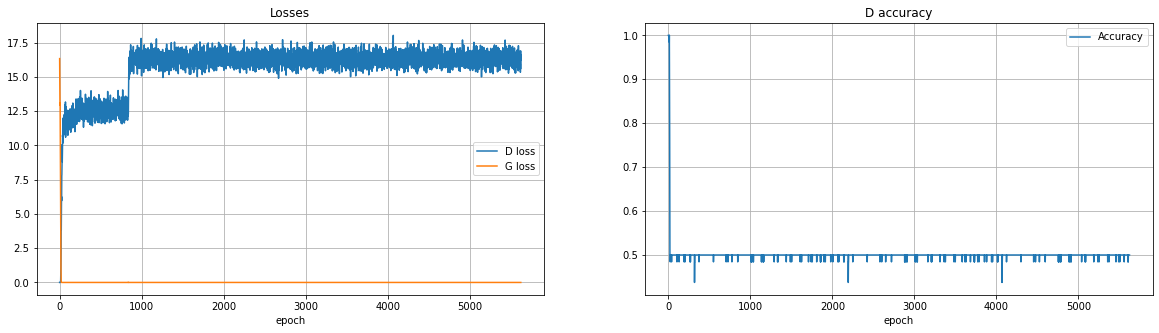

----EPOCH 3-----
0 [D loss: 16.3121,	 acc.: 50.00%]	[G loss: 0.0000]


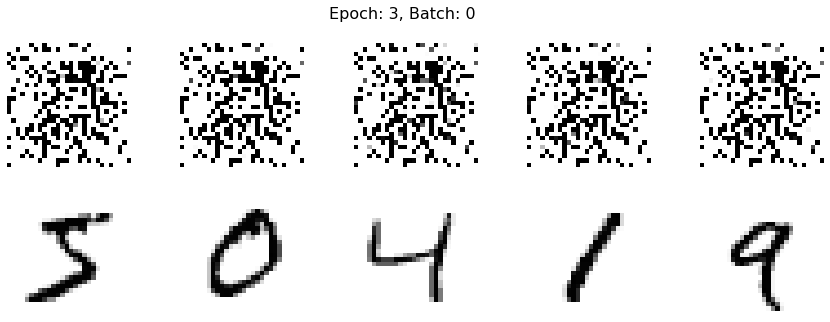

50 [D loss: 16.3162,	 acc.: 50.00%]	[G loss: 0.0000]
100 [D loss: 16.2796,	 acc.: 50.00%]	[G loss: 0.0000]
150 [D loss: 16.8247,	 acc.: 50.00%]	[G loss: 0.0000]
200 [D loss: 15.8092,	 acc.: 50.00%]	[G loss: 0.0000]
250 [D loss: 16.2787,	 acc.: 50.00%]	[G loss: 0.0000]
300 [D loss: 16.4724,	 acc.: 50.00%]	[G loss: 0.0000]
350 [D loss: 17.2804,	 acc.: 50.00%]	[G loss: 0.0000]
400 [D loss: 15.6575,	 acc.: 50.00%]	[G loss: 0.0000]
450 [D loss: 15.7926,	 acc.: 50.00%]	[G loss: 0.0000]
500 [D loss: 16.0168,	 acc.: 50.00%]	[G loss: 0.0000]


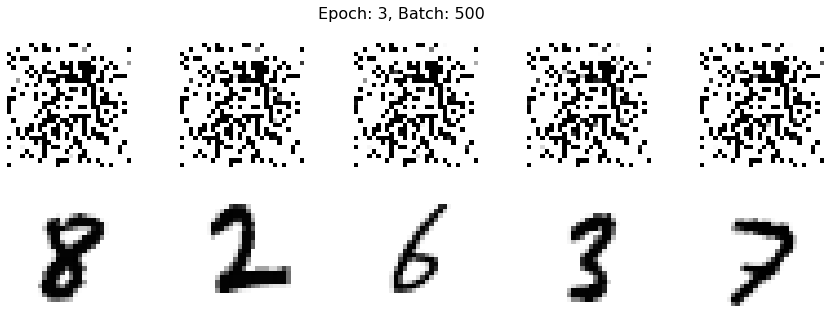

550 [D loss: 17.0870,	 acc.: 48.44%]	[G loss: 0.0000]
600 [D loss: 15.9273,	 acc.: 50.00%]	[G loss: 0.0000]
650 [D loss: 16.7303,	 acc.: 50.00%]	[G loss: 0.0000]
700 [D loss: 16.0674,	 acc.: 50.00%]	[G loss: 0.0000]
750 [D loss: 16.8130,	 acc.: 50.00%]	[G loss: 0.0000]
800 [D loss: 15.9486,	 acc.: 50.00%]	[G loss: 0.0000]
850 [D loss: 15.9756,	 acc.: 50.00%]	[G loss: 0.0000]
900 [D loss: 16.4612,	 acc.: 50.00%]	[G loss: 0.0000]
950 [D loss: 17.1974,	 acc.: 50.00%]	[G loss: 0.0000]
1000 [D loss: 16.5750,	 acc.: 50.00%]	[G loss: 0.0000]


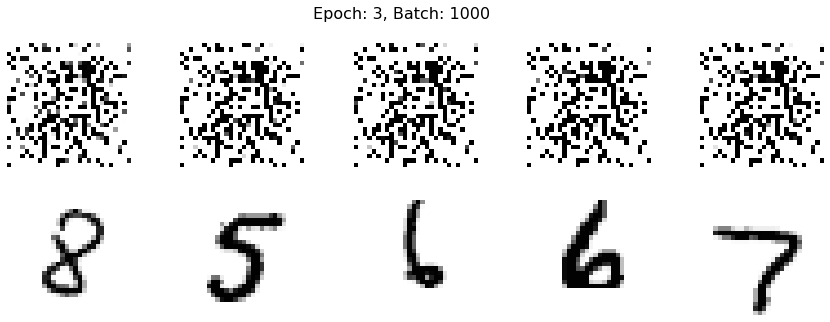

1050 [D loss: 16.6092,	 acc.: 50.00%]	[G loss: 0.0000]
1100 [D loss: 15.5108,	 acc.: 50.00%]	[G loss: 0.0000]
1150 [D loss: 16.2574,	 acc.: 50.00%]	[G loss: 0.0000]
1200 [D loss: 17.4817,	 acc.: 50.00%]	[G loss: 0.0000]
1250 [D loss: 16.0024,	 acc.: 50.00%]	[G loss: 0.0000]
1300 [D loss: 16.5839,	 acc.: 50.00%]	[G loss: 0.0000]
1350 [D loss: 16.9855,	 acc.: 50.00%]	[G loss: 0.0000]
1400 [D loss: 16.0991,	 acc.: 50.00%]	[G loss: 0.0000]
1450 [D loss: 16.2856,	 acc.: 50.00%]	[G loss: 0.0000]
1500 [D loss: 16.4126,	 acc.: 50.00%]	[G loss: 0.0000]


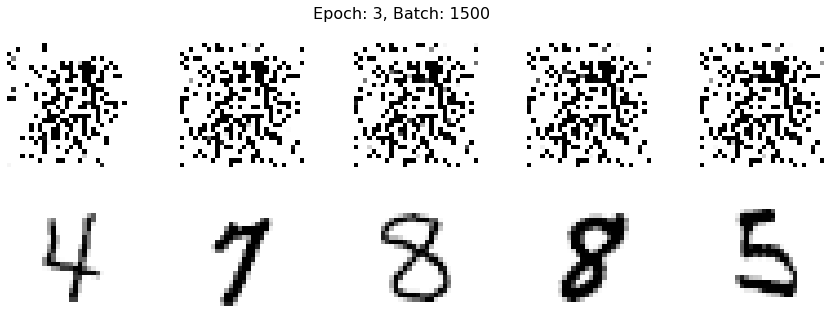

1550 [D loss: 16.1299,	 acc.: 50.00%]	[G loss: 0.0000]
1600 [D loss: 16.6439,	 acc.: 50.00%]	[G loss: 0.0000]
1650 [D loss: 17.3367,	 acc.: 50.00%]	[G loss: 0.0000]
1700 [D loss: 15.5511,	 acc.: 50.00%]	[G loss: 0.0000]
1750 [D loss: 16.2672,	 acc.: 50.00%]	[G loss: 0.0000]
1800 [D loss: 16.0278,	 acc.: 50.00%]	[G loss: 0.0000]
1850 [D loss: 16.1548,	 acc.: 50.00%]	[G loss: 0.0000]


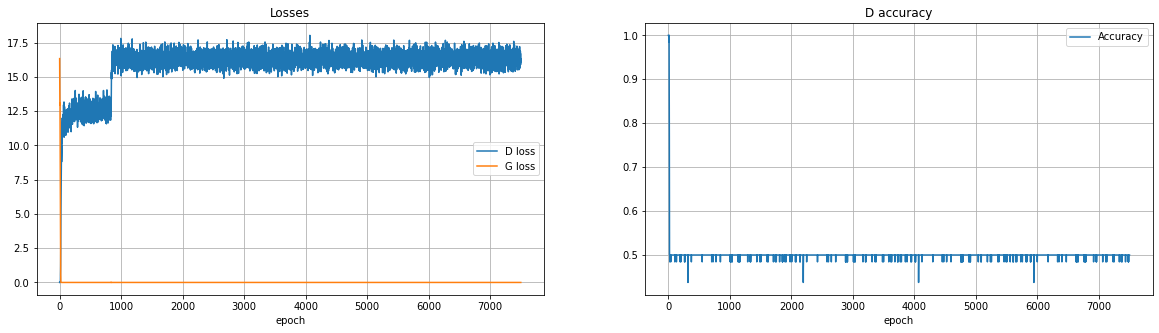

----EPOCH 4-----
0 [D loss: 16.5600,	 acc.: 50.00%]	[G loss: 0.0000]


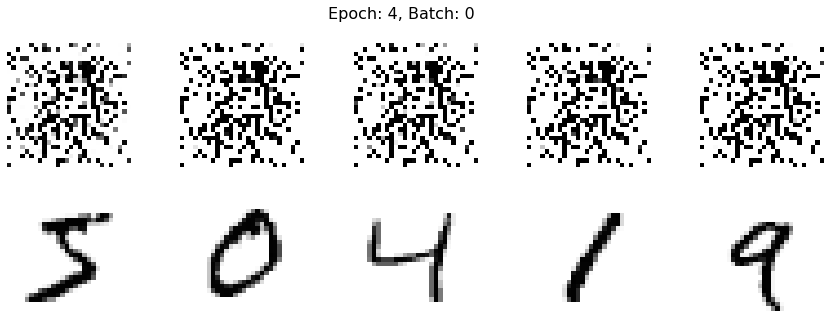

50 [D loss: 16.1403,	 acc.: 50.00%]	[G loss: 0.0000]
100 [D loss: 15.2651,	 acc.: 50.00%]	[G loss: 0.0000]
150 [D loss: 16.5811,	 acc.: 50.00%]	[G loss: 0.0000]
200 [D loss: 16.3765,	 acc.: 50.00%]	[G loss: 0.0000]
250 [D loss: 16.0965,	 acc.: 50.00%]	[G loss: 0.0000]
300 [D loss: 16.5175,	 acc.: 50.00%]	[G loss: 0.0000]
350 [D loss: 17.0364,	 acc.: 50.00%]	[G loss: 0.0000]
400 [D loss: 16.1652,	 acc.: 50.00%]	[G loss: 0.0000]
450 [D loss: 17.0413,	 acc.: 50.00%]	[G loss: 0.0000]
500 [D loss: 16.4335,	 acc.: 50.00%]	[G loss: 0.0000]


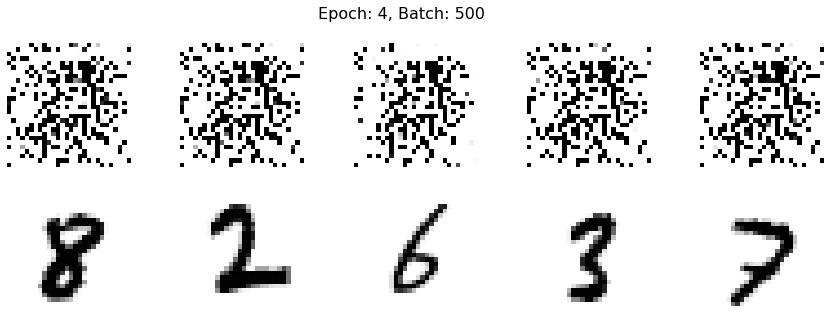

550 [D loss: 16.5683,	 acc.: 48.44%]	[G loss: 0.0000]
600 [D loss: 16.3265,	 acc.: 50.00%]	[G loss: 0.0000]
650 [D loss: 16.2255,	 acc.: 50.00%]	[G loss: 0.0000]
700 [D loss: 16.9125,	 acc.: 50.00%]	[G loss: 0.0000]
750 [D loss: 16.2392,	 acc.: 50.00%]	[G loss: 0.0000]
800 [D loss: 16.5276,	 acc.: 50.00%]	[G loss: 0.0000]
850 [D loss: 15.2529,	 acc.: 50.00%]	[G loss: 0.0000]
900 [D loss: 15.7224,	 acc.: 50.00%]	[G loss: 0.0000]
950 [D loss: 15.7864,	 acc.: 50.00%]	[G loss: 0.0000]
1000 [D loss: 16.7272,	 acc.: 50.00%]	[G loss: 0.0000]


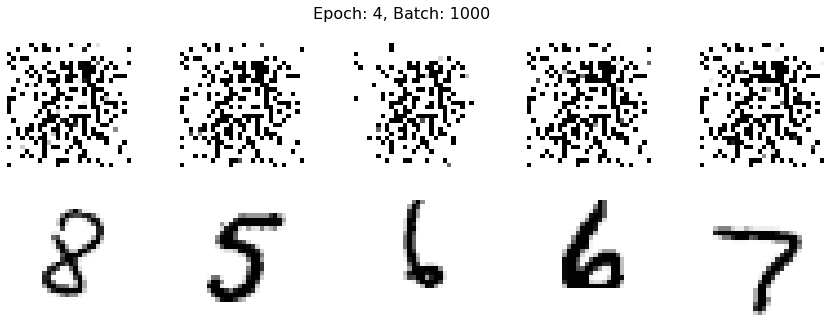

1050 [D loss: 16.5592,	 acc.: 50.00%]	[G loss: 0.0000]
1100 [D loss: 16.5773,	 acc.: 50.00%]	[G loss: 0.0000]
1150 [D loss: 15.7847,	 acc.: 50.00%]	[G loss: 0.0000]
1200 [D loss: 16.7691,	 acc.: 50.00%]	[G loss: 0.0000]
1250 [D loss: 16.4866,	 acc.: 50.00%]	[G loss: 0.0000]
1300 [D loss: 15.7282,	 acc.: 50.00%]	[G loss: 0.0000]
1350 [D loss: 16.0561,	 acc.: 50.00%]	[G loss: 0.0000]
1400 [D loss: 15.3904,	 acc.: 50.00%]	[G loss: 0.0000]
1450 [D loss: 16.6208,	 acc.: 50.00%]	[G loss: 0.0000]
1500 [D loss: 15.9399,	 acc.: 50.00%]	[G loss: 0.0000]


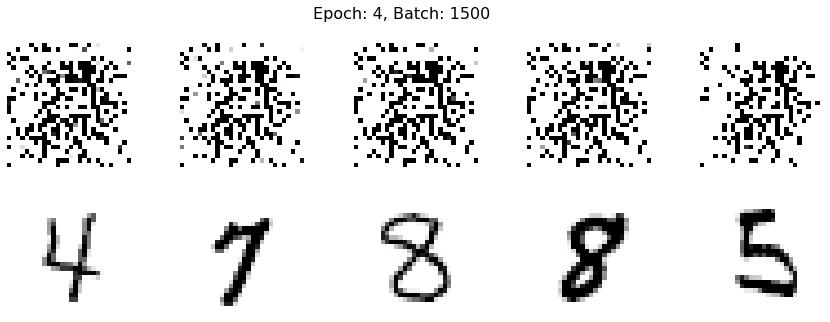

1550 [D loss: 16.0175,	 acc.: 50.00%]	[G loss: 0.0000]
1600 [D loss: 16.4246,	 acc.: 50.00%]	[G loss: 0.0000]
1650 [D loss: 16.2751,	 acc.: 50.00%]	[G loss: 0.0000]
1700 [D loss: 16.5590,	 acc.: 50.00%]	[G loss: 0.0000]
1750 [D loss: 16.3170,	 acc.: 50.00%]	[G loss: 0.0000]
1800 [D loss: 15.9502,	 acc.: 50.00%]	[G loss: 0.0000]
1850 [D loss: 16.3936,	 acc.: 50.00%]	[G loss: 0.0000]


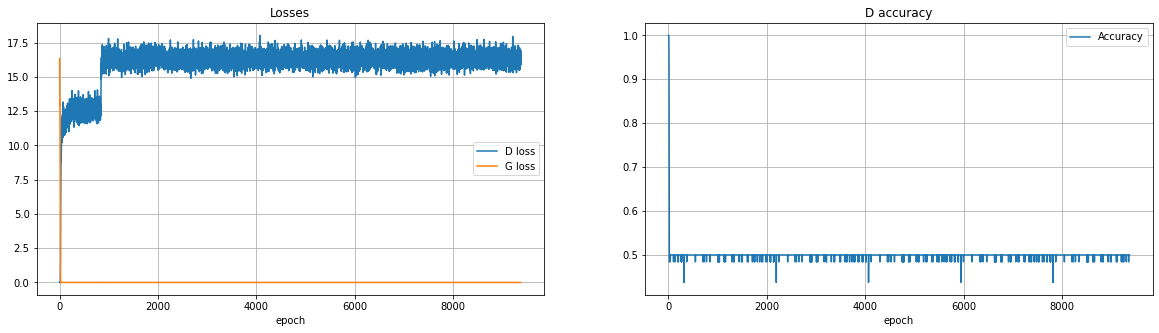

----EPOCH 5-----
0 [D loss: 16.4910,	 acc.: 50.00%]	[G loss: 0.0000]


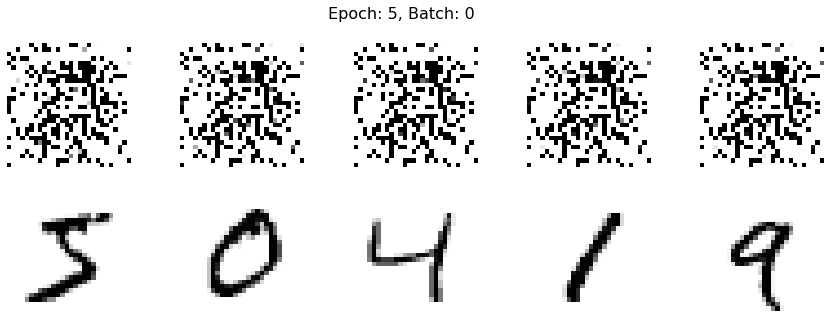

50 [D loss: 16.1481,	 acc.: 50.00%]	[G loss: 0.0000]
100 [D loss: 16.4921,	 acc.: 50.00%]	[G loss: 0.0000]
150 [D loss: 16.6543,	 acc.: 50.00%]	[G loss: 0.0000]
200 [D loss: 16.5500,	 acc.: 50.00%]	[G loss: 0.0000]
250 [D loss: 16.9870,	 acc.: 50.00%]	[G loss: 0.0000]
300 [D loss: 16.7042,	 acc.: 50.00%]	[G loss: 0.0000]
350 [D loss: 16.8913,	 acc.: 50.00%]	[G loss: 0.0000]
400 [D loss: 17.1107,	 acc.: 50.00%]	[G loss: 0.0000]
450 [D loss: 16.0581,	 acc.: 50.00%]	[G loss: 0.0000]
500 [D loss: 15.4326,	 acc.: 50.00%]	[G loss: 0.0000]


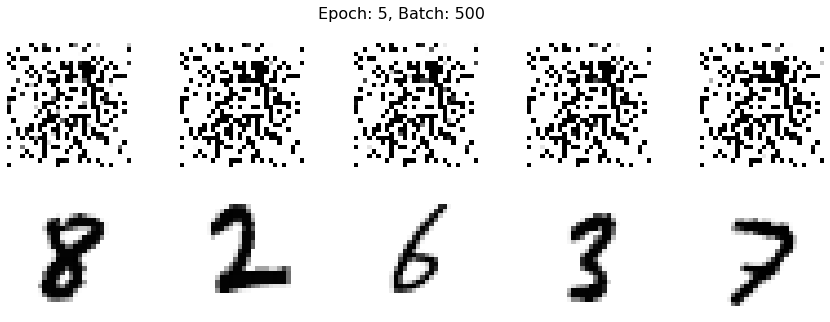

550 [D loss: 16.5200,	 acc.: 48.44%]	[G loss: 0.0000]
600 [D loss: 15.8713,	 acc.: 50.00%]	[G loss: 0.0000]
650 [D loss: 15.8360,	 acc.: 50.00%]	[G loss: 0.0000]
700 [D loss: 16.3171,	 acc.: 50.00%]	[G loss: 0.0000]
750 [D loss: 15.8752,	 acc.: 50.00%]	[G loss: 0.0000]
800 [D loss: 16.0539,	 acc.: 50.00%]	[G loss: 0.0000]
850 [D loss: 16.2958,	 acc.: 50.00%]	[G loss: 0.0000]
900 [D loss: 15.7641,	 acc.: 50.00%]	[G loss: 0.0000]
950 [D loss: 16.1879,	 acc.: 50.00%]	[G loss: 0.0000]
1000 [D loss: 16.4297,	 acc.: 50.00%]	[G loss: 0.0000]


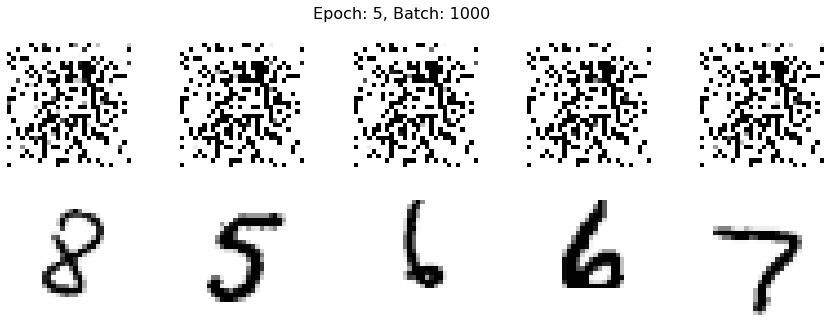

1050 [D loss: 16.8352,	 acc.: 50.00%]	[G loss: 0.0000]
1100 [D loss: 16.5710,	 acc.: 50.00%]	[G loss: 0.0000]
1150 [D loss: 16.7226,	 acc.: 50.00%]	[G loss: 0.0000]


KeyboardInterrupt: ignored

In [ ]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

---

Creado por **Guillermo Iglesias** (guillermo.iglesias@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">